In [1]:
from pprint import pprint
from pycitylayers.client import Client
from pycitylayers.utils import PointGQL, PolygonGQL
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx


In [2]:
client = Client().create(source='cerc')
coll = client.collection
tb=coll[6][0]
tb
print(tb)
query_geometry = PointGQL().point(-73.570552324815,45.530402345761175)
print( query_geometry )


query_options = {
    # 'columns': ['index', 'built_area', 'geom', 'year_built'], 
    'nrows': 10000, 
    'skiprows': 0,
    'geometry_operation': 'distance_from_point',
    'geom_distance': 0.0005,
    'geometry': query_geometry,
    'crs_epsg': 4326,
}

data_lots = tb.query_simple( **query_options )
data_lots.head()

Fetching Metadata. Please Wait ...
---------- Table:0 ----------
Name:		building_lots 
Description:	 
Format:		CSV 

{'geometry': {'type': 'Point', 'coordinates': [-73.570552324815, 45.530402345761175], 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}}}}


,borough_id,building_number,built_area,dwelling_number,firstletter_apt,geom,index,land_area,landuse_code,landuse_text,lastletter_apt,max_floors,municipality_code,nad83_registration,street_name,street_number,uid,unit_category,unit_number,year_built
0,REM21,4218,454,1,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",4602,52,1000,Logement,0,1,50,9943-34-1120-6-001-0004,avenue Papineau (MTL),4218,5011916,Condominium,0,1910
1,REM21,4235,219,3,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",21512,284,1000,Logement,0,2,50,9943-23-5995-0-000-0000,rue Marquette (MTL),4235,1030537,Régulier,0,1885
2,REM21,4220,362,5,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",22960,239,1000,Logement,0,3,50,9943-23-5535-4-000-0000,rue Marquette (MTL),4224,1030019,Régulier,0,1926
3,REM21,1699,1255,16,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",23674,644,1000,Logement,0,3,50,9943-34-3605-4-000-0000,rue Rachel Est (MTL),1699,1033787,Régulier,0,1927
4,REM21,1651,466,2,0,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",23781,259,1000,Logement,0,3,50,9943-33-0449-2-000-0000,rue Rachel Est (MTL),1653,1033777,Régulier,0,1915


In [3]:
len(data_lots)

24

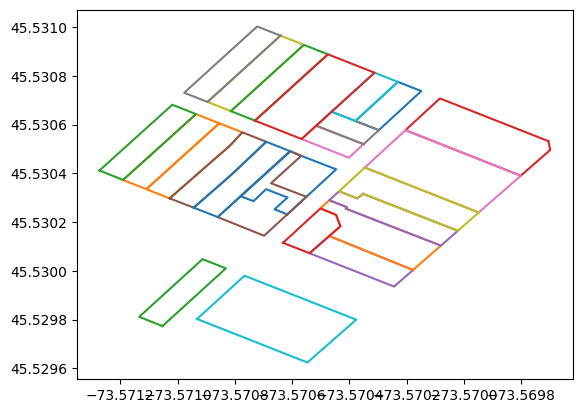

# centroids: 24
# polygons: 24


In [4]:
centroid=[]
for i in range(len(data_lots)):
    vertex = data_lots.iloc[i,:]["geom"]["coordinates"][0]
    polygon1=Polygon(vertex)
    polygon1
    centroid.append(polygon1.centroid)
    plt.plot(*polygon1.exterior.xy)
plt.show()
print("# centroids:",len(centroid))
print("# polygons:",len(data_lots))

### Having extracted the centroids, the graph can be generated. Also, the coordinates of the centroid points are used to plot them. 

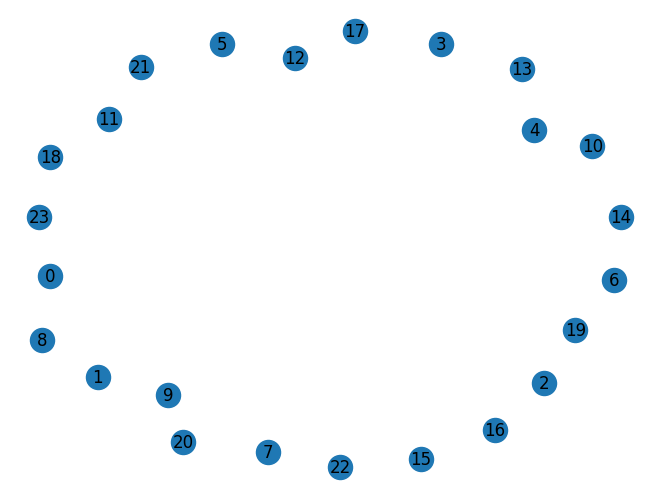

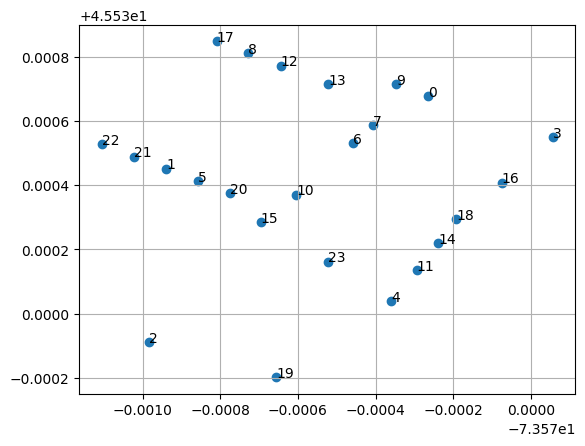

In [22]:
# create graph
G=nx.Graph()
for i in range(len(centroid)):
    G.add_node(i,pos=(centroid[i].x,centroid[i].y))
nx.draw(G, with_labels=True)

# extract position attributes of the points
pos=nx.get_node_attributes(G,'pos')

xs,ys,label=[],[],[]
for i in range(len(pos)):
    xs.append(pos[i][0])
    ys.append(pos[i][1])
    label.append(i)

# plot the centroids - plt

n=list(G.nodes)
fig, ax = plt.subplots()
ax.scatter(xs, ys)
plt.grid()

for i, txt in enumerate(n):
    ax.annotate(txt, (xs[i], ys[i]))
plt.show()

# plot the centroids - plotly
import plotly.express as px
px.scatter(x=xs,y=ys,width=1200, height=800,text=label)

In [34]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23))

### The graph is created and can be used in the MESA space definition

In [23]:
import mesa

In [35]:



class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1


    # def move(self):
    #     possible_steps = self.model.grid.get_neighborhood(
    #         self.pos,
    #         moore=True,
    #         include_center=False)
    #     new_position = self.random.choice(possible_steps)
    #     self.model.grid.move_agent(self, new_position)
    
    # def give_money(self):
    #     cellmates = self.model.grid.get_cell_list_contents([self.pos])
    #     if len(cellmates) > 1:
    #         other = self.random.choice(cellmates)
    #         other.wealth += 1
    #         self.wealth -= 1



    def step(self):
        # self.move()
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print("Agent #" + str(self.unique_id) + ", Wealth:"+str(self.wealth)+",Location:"+str(self.pos))
        # if self.wealth > 0:
        #     self.give_money()

class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        # self.grid = mesa.space.MultiGrid(width, height, True)
        self.grid = mesa.space.NetworkGrid(G)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True
        
        # Create agents
        for i, node in enumerate(G.nodes()):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            # x = self.random.randrange(self.grid.width)
            # y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a,node)

        self.datacollector = mesa.DataCollector(
             agent_reporters={"Wealth": "wealth",}
        )

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

In [37]:
model = MoneyModel(len(centroid))
for i in range(1):
    model.step()

Agent #11, Wealth:1,Location:11
Agent #18, Wealth:1,Location:18
Agent #14, Wealth:1,Location:14
Agent #7, Wealth:1,Location:7
Agent #23, Wealth:1,Location:23
Agent #0, Wealth:1,Location:0
Agent #12, Wealth:1,Location:12
Agent #16, Wealth:1,Location:16
Agent #6, Wealth:1,Location:6
Agent #21, Wealth:1,Location:21
Agent #5, Wealth:1,Location:5
Agent #1, Wealth:1,Location:1
Agent #13, Wealth:1,Location:13
Agent #8, Wealth:1,Location:8
Agent #15, Wealth:1,Location:15
Agent #20, Wealth:1,Location:20
Agent #2, Wealth:1,Location:2
Agent #19, Wealth:1,Location:19
Agent #10, Wealth:1,Location:10
Agent #9, Wealth:1,Location:9
Agent #17, Wealth:1,Location:17
Agent #3, Wealth:1,Location:3
Agent #22, Wealth:1,Location:22
Agent #4, Wealth:1,Location:4
